In [1]:
import cellprofiler.modules.trackobjects as t
import cellprofiler.pipeline as cpp
import cellprofiler.image as cpi
import cellprofiler.object as cpo

def track_cells(frames):
    pipeline = cpp.Pipeline()

    # Create the image set list
    image_set_list = cpi.ImageSetList()

    # Add the frames to the image set list
    for i, frame in enumerate(frames):
        image_set = image_set_list.get_image_set(i)
        image_set.add("frame", cpi.Image(frame))

    # Create a TrackObjects module
    track_module = t.TrackObjects()
    track_module.module_num = 1
    pipeline.add_module(track_module)

    # Create an object set
    object_set = cpo.ObjectSet()

    # Run the pipeline
    for i in range(len(frames)):
        image_set = image_set_list.get_image_set(i)
        module = pipeline.get_module(i+1)
        module.module_num = i+1

        if i > 0:
            module.set_module_inputs(
                object_set=object_set,
                current_image=image_set.get_image("frame"),
                current_objects=prev_objects
            )

        module.prepare_run(image_set, object_set)
        module.run(image_set, object_set)
        prev_objects = object_set.get_objects(i+1, "cells")

    # Get the tracked cells
    cell_props_all = []
    for i, frame in enumerate(frames):
        cell_props = object_set.get_objects(i+1, "cells")
        cell_props["frame"] = i
        cell_props_all.append(cell_props)

    cell_props_all = pd.concat(cell_props_all)

    # Convert the centroid coordinates to a more readable format
    cell_props_all["centroid"] = cell_props_all["centroid"].apply(lambda c: (c[1], c[0]))

    # Match cells in each frame to cells in the previous frame, based on centroid distance
    prev_frame = None
    for i, frame in enumerate(frames):
        current_props = cell_props_all[cell_props_all["frame"] == i]
        if prev_frame is not None:
            prev_props = cell_props_all[cell_props_all["frame"] == i-1]
            for cell in current_props:
                overlaps = [cell.overlap(other) for other in prev_props]
                if max(overlaps) > 0.5:
                    cell_idx = overlaps.index(max(overlaps))
                    prev_cell = prev_props.iloc[cell_idx]
                    cell_props_all.loc[cell_props_all["label"] == cell.label, "centroid_prev"] = prev_cell.centroid

        prev_frame = frame

    return cell_props_all


ModuleNotFoundError: No module named 'cellprofiler'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data into a pandas dataframe
df = pd.read_csv("Exp_grpExp_grp.csv", delimiter=",")

# Specify the ObjectNumbers you want to include
object_numbers = [1, 2, 3]

# Filter the dataframe to only include rows with the specified ObjectNumbers
filtered_df = df[df["Object_Number"].isin(object_numbers)]

# Plot the trajectories of the selected cells
fig, ax = plt.subplots()
for object_number, group in filtered_df.groupby("Object_Number"):
    ax.plot(group["Location_Center_X"], group["Location_Center_Y"], label=f"Cell {object_number}")
ax.legend()
plt.show()

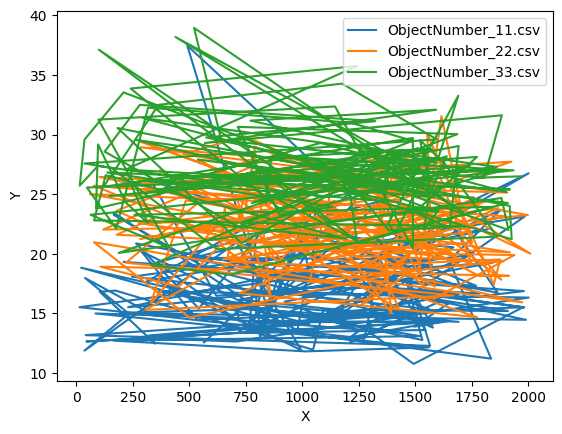

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

path = "Exp_grp/"
files = os.listdir(path)

files = ['ObjectNumber_11.csv','ObjectNumber_22.csv','ObjectNumber_33.csv']

fig, ax = plt.subplots()
for file in files:
    df = pd.read_csv(os.path.join(path, file))
    df = df[df['ObjectNumber'].isin([11, 22, 33])]  # subset to desired cells
    ax.plot(df['Location_Center_X'], df['Location_Center_Y'], label=file)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

def plot_trajectory(file_num):
    obj_num = file_num
    # Read the csv file corresponding to the specified file number
    file_name = f'Exp_grp/ObjectNumber_{file_num}.csv'
    df = pd.read_csv(file_name)
    
    # Extract the data for the specified object number
    obj_df = df[df['ObjectNumber'] == obj_num]
    
    # Extract the x and y coordinates of the object's trajectory
    x = obj_df['Location_Center_X']
    y = obj_df['Location_Center_Y']
    
    # Background Image
    plt.imread('Data\Exp_grp\image001.jpg')
    plt.imshow('Data\Exp_grp\image001.jpg')
    # Create a scatter plot of the object's trajectory
    plt.scatter(x, y)
    
    # Plot the starting point and final point as red circles
    plt.plot(x.iloc[0], y.iloc[0], 'o', color='red', markersize=10)
    plt.plot(x.iloc[-1], y.iloc[-1], 'o', color='red', markersize=10)
    
    # Plot a line connecting the points in the trajectory
    plt.plot(x, y, color='black', linewidth=2)
    
    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Trajectory of Object {obj_num} in {file_name}')
    
    # Show the plot
    plt.show()


TypeError: Image data of dtype <U25 cannot be converted to float

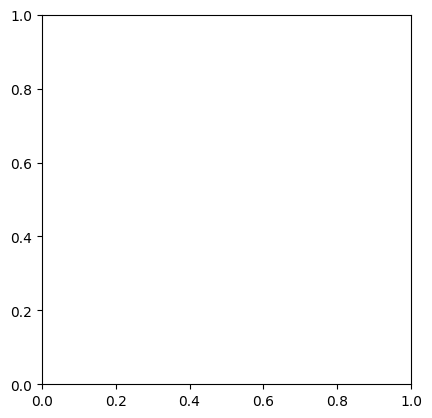

In [36]:
plot_trajectory(1112)
